In [116]:
import matplotlib.pyplot as plt
import torch
import pytorch_measure as pm
import numpy as np
N = 5 # number of atoms
M = 40 # Number of datapoints
amin = -5
amax = 3
verbose = True
dev = 'cpu'


torch.manual_seed(1)

def regression_model(a, x):
    return a+x

x = torch.linspace(0, 10, M).view(-1, 1)
#data = regression_model(torch.randn(M).to(dev) - 2, x).view(-1, 1)
data = -2 + x + torch.from_numpy(np.random.normal(0,1,(M,1))).float() # The way of the Sergei
w = np.array(np.random.uniform(0, 1, size=N)) # The way of the Sergei
w = torch.tensor(w)
#w = torch.rand(N,dtype=torch.float).to(dev)
w = torch.nn.parameter.Parameter(w/w.sum())
l = torch.linspace(amin, amax, N, requires_grad=False).to(dev)

index = []
for i in range(M):
    ab = (regression_model(l, x[i]) - data[i]).abs()
    index.append(torch.argmin(ab))

def NLLLoss(m:list[pm.Measure]):
    return -(m[0].weights[index]).log().sum()

#sd = (l[index] - data)**2
def WardLoss(w):
    return sum(sd * w[index])

def K(d):
        return 1/np.sqrt(2*np.pi)*np.exp(-d**2/2)
h=1.06*M**(-1/5)
# K( (y - yj) / h )
kde_mat = K((data.view(-1,1) - regression_model(l, x)) / h)

#a = torch.sum(kde_mat, dim=0)

def KDENLLLoss(m):
    return -(torch.matmul(kde_mat, m[0].weights.view(-1,1)) / (M*h)).log().sum()


Epoch: 0          Loss: 84.084231794 LR: 0.100000000
Epoch: 1          Loss: 70.931438117 LR: 0.100000000
Epoch: 2          Loss: 60.669221833 LR: 0.100000000
Epoch: 3          Loss: 53.343343427 LR: 0.100000000
Epoch: 4          Loss: 46.479961849 LR: 0.100000000
Epoch: 5          Loss: 41.854278871 LR: 0.100000000
Epoch: 6          Loss: 37.928478371 LR: 0.100000000
Epoch: 7          Loss: 35.831748531 LR: 0.100000000
Epoch: 8          Lr was reduced to: 0.070000000
Epoch: 9          Loss: 36.539099536 LR: 0.070000000
Epoch: 10         Lr was reduced to: 0.049000000
Epoch: 11         Loss did not change (inf)
Epoch: 12         Loss did not change (inf)
Epoch: 13         Loss did not change (inf)
Epoch: 14         Loss did not change (inf)
Epoch: 15         Loss did not change (inf)
Epoch: 16         Loss did not change (inf)
Epoch: 17         Loss did not change (inf)
Epoch: 18         Loss did not change (inf)
Epoch: 19         Loss did not change (inf)
Epoch: 20         Loss did no

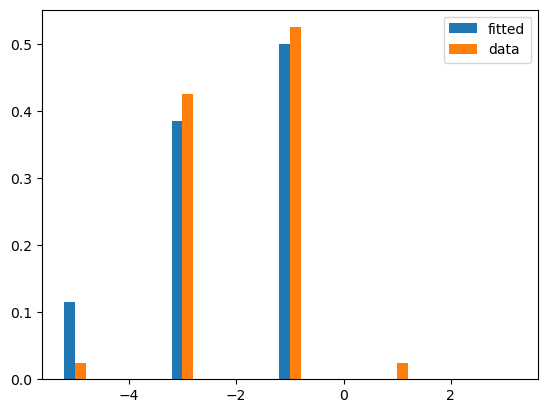

In [117]:
measure = pm.Measure(locations=l, weights=w, device=dev)
opt = pm.Optimizer([measure], lr=1e-1)
opt.minimize(NLLLoss, verbose=True, print_freq=1, max_epochs=1000, tol_const=1e-2)

plt.plot()

mu=0 #Create true values
sigma=1
xs = l.detach()
y=1/(np.sqrt(2*np.pi)*sigma)*torch.exp(-(xs+2-mu)**2/(2*sigma**2))
y/=sum(y) #Normalize

'''
measure.visualize()
#plt.bar(l-0.1, torch.sum(kde_mat, dim=0)/torch.sum(kde_mat), zorder=0, width=0.1)
plt.scatter(xs, y, zorder=2, label="True distribution")
plt.legend()

plt.show()
'''
### sergei visualize ###
locations_grid_size = (amax - amin) / (N - 1)
bins=torch.linspace(amin - locations_grid_size / 2, amax + locations_grid_size / 2, N + 1)
h,b = torch.histogram(data - x, bins=bins)
midpoints = (b[1:] + b[:-1]) / 2

# side-by-side histogram. Can it be done smarter?
plt.bar(midpoints - 0.1, measure.weights.tolist(), width = 0.2, label='fitted')
plt.bar(midpoints + 0.1, h / h.sum(), width = 0.2, label='data')
plt.legend(loc='upper right')
plt.show()

#LR         to 1e-4             to 1e-5
#1e-3  -  2147.958496094        2145.816650391
#1e-2  -  2147.958496094        2145.816650391
#1e-1  -  2149.463867188        2145.826660156